In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

## for preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import matplotlib.pyplot as plt
import seaborn as sns

import warnings 
warnings.filterwarnings("ignore")

In [2]:
## Problem statement

In [3]:
## data gatharing
dataset = pd.read_csv("insurance.csv")
dataset.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
dataset.duplicated().sum()

1

In [6]:
dataset.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [7]:
dataset.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [8]:
dataset.sex.unique()

array(['female', 'male'], dtype=object)

In [9]:
dataset.smoker.unique()

array(['yes', 'no'], dtype=object)

In [10]:
dataset.region.unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

In [11]:
## EDA (Exploratory data analysis)
dataset.isna().sum()/len(dataset) * 100

age         0.0
sex         0.0
bmi         0.0
children    0.0
smoker      0.0
region      0.0
charges     0.0
dtype: float64

In [12]:
dataset.duplicated().sum()

1

In [13]:
### Creating a back up before droping the duplicates rows
backup = dataset.copy()

In [14]:
dataset[dataset.duplicated()]

,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


In [15]:
dataset.groupby(["age", "sex", "bmi","region"]).get_group((19, "male", 30.59, "northwest"))

,age,sex,bmi,children,smoker,region,charges
195,19,male,30.59,0,no,northwest,1639.5631
581,19,male,30.59,0,no,northwest,1639.5631


In [16]:
dataset.drop_duplicates(ignore_index=True,inplace=True)

In [17]:
dataset.duplicated().sum()

0

In [18]:
dataset.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [19]:
col = dataset.columns
col

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [20]:
conti_col = ['age', 'bmi', 'children']
cat_col = ['sex', 'smoker', 'region']
target = ["charges"]

<AxesSubplot: >

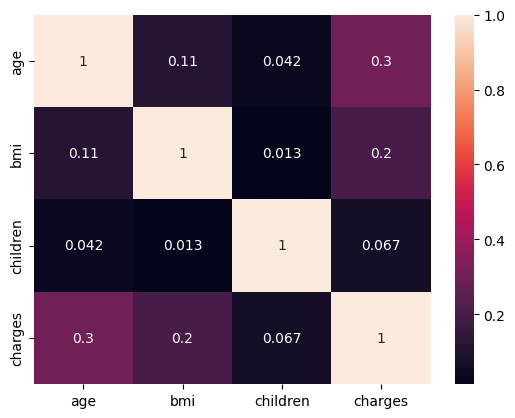

In [21]:
## check for colrelations in contineoues variables
sns.heatmap(dataset.corr(), annot=True)

In [22]:
## Multicolinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = []
for i in range(len(conti_col)):
    vf = variance_inflation_factor(dataset[conti_col].to_numpy(), i)
    vif.append(vf)
    
vif = pd.Series(vif, conti_col)

In [23]:
vif.sort_values()

children    1.797373
age         7.542947
bmi         7.856685
dtype: float64

<AxesSubplot: >

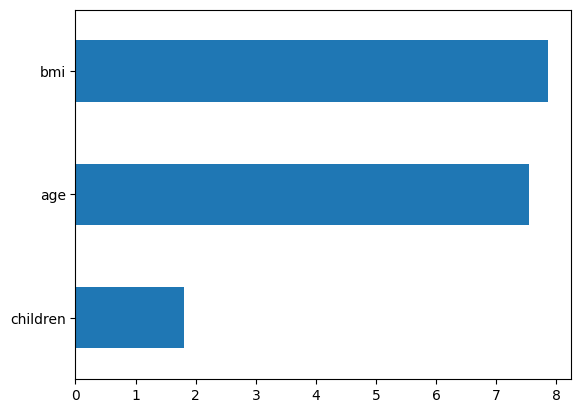

In [24]:
vif.sort_values().plot(kind="barh")

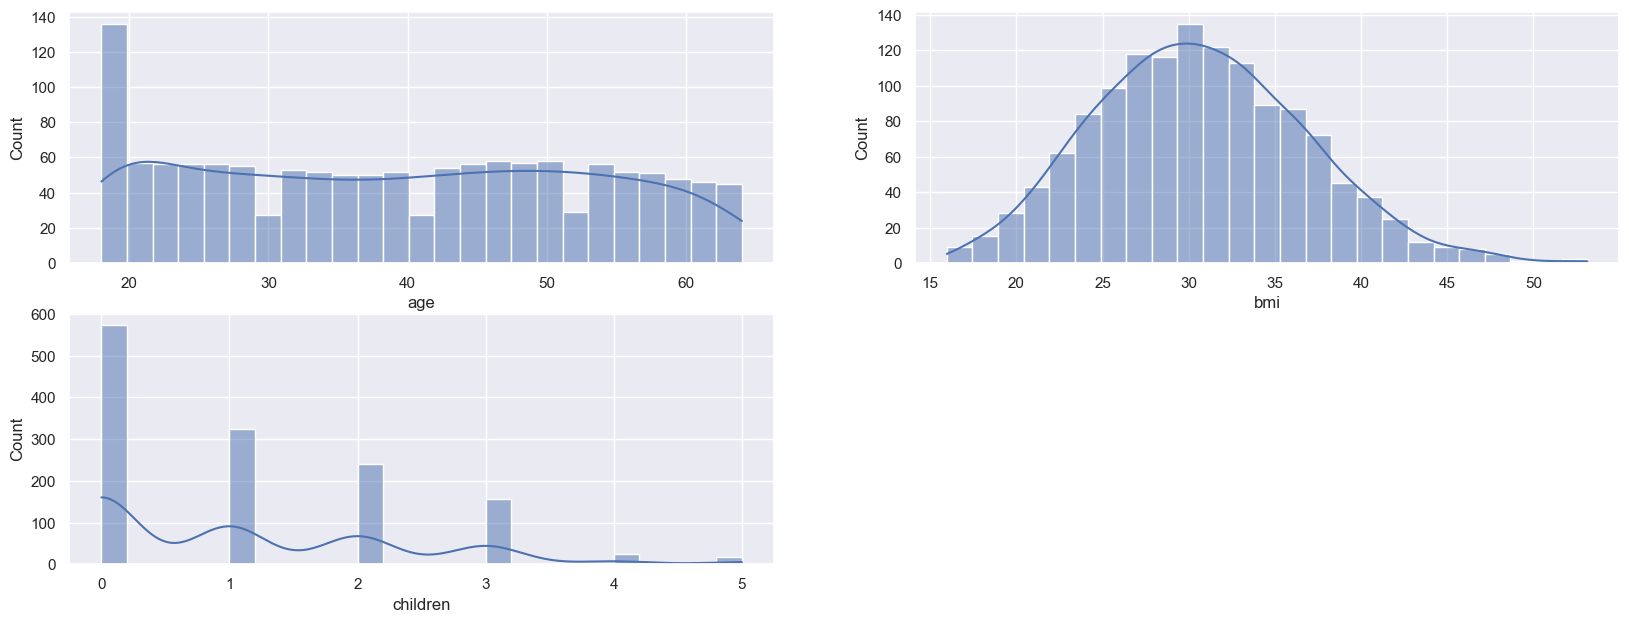

In [25]:
## check for normal distribution
sns.set_theme(color_codes=True)
plt.figure(figsize=(20,15))
for i in range(len(conti_col)):
    plt.subplot(4,2,i+1)
    sns.histplot(data=dataset, x=conti_col[i], kde=True, bins=25)

In [26]:
dataset.skew()

age         0.054781
bmi         0.283914
children    0.937421
charges     1.515391
dtype: float64

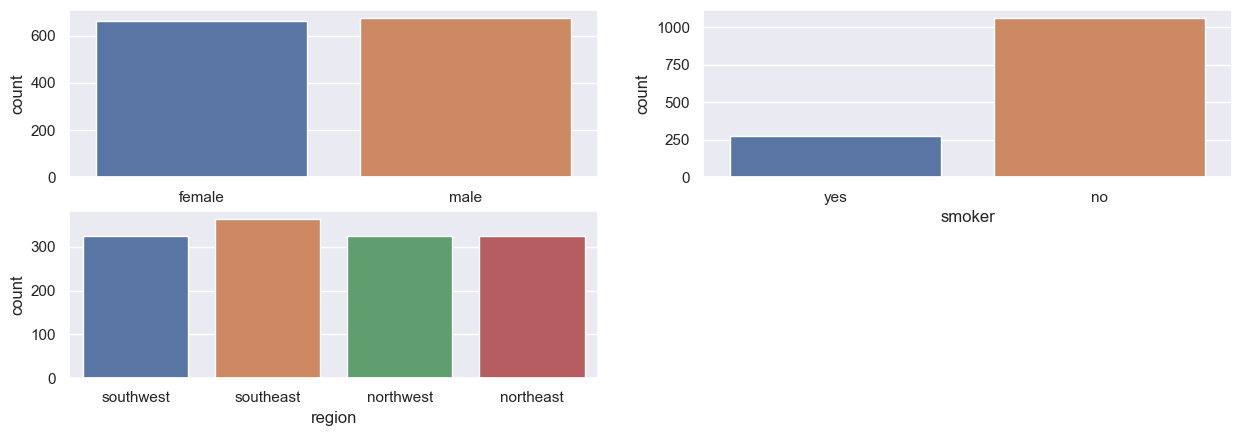

In [27]:
## Count plot of the categorical columns
plt.figure(figsize=(15,10))
for i in range(len(cat_col)):
    plt.subplot(4,2,i+1)
    sns.countplot(data=dataset, x=cat_col[i])

In [28]:
dataset.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [29]:
dataset_data = pd.get_dummies(data=dataset,columns=["sex", "smoker"], drop_first=True)

In [30]:
dataset_data.head()

,age,bmi,children,region,charges,sex_male,smoker_yes
0,19,27.900,0,southwest,16884.92400,0,1
1,18,33.770,1,southeast,1725.55230,1,0
2,28,33.000,3,southeast,4449.46200,1,0
3,33,22.705,0,northwest,21984.47061,1,0
4,32,28.880,0,northwest,3866.85520,1,0


### Model training

In [31]:
X = dataset_data.drop(["charges", "region"], axis=1)
y = dataset_data["charges"]

In [32]:
## first we won't keep the random state first lets look at the accuracies on all 
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=555)

In [33]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [34]:
y_pred_te = lr.predict(x_test)
y_pred_tr = lr.predict(X_train)

In [35]:
y_pred_te[:10]

array([ 6760.17511766,  7420.86281742,  9770.06836532, 11434.44799257,
        1137.55138465,  8134.83119994,  6464.49481779, 39099.30148102,
        8400.44087732, 37210.97327662])

In [36]:
y_test[:10]

671      4399.73100
518      5240.76500
1002    21232.18226
334     19144.57652
31       2198.18985
318      7421.19455
1237     6985.50695
330     48517.56315
43       6313.75900
252     44260.74990
Name: charges, dtype: float64

In [37]:
X.shape

(1337, 5)

In [38]:
MSE = mean_squared_error(y_test, y_pred_te)
print(f"Mean Squared Error : {MSE}")

MAE = mean_absolute_error(y_test, y_pred_te)
print(f"Mean Absolute Error : {MAE}")

RMSE = np.sqrt(MSE)
print(f"Root Mean Squared Error : {RMSE}")

R_squared = r2_score(y_test, y_pred_te)
print(f"R_Squared : {R_squared}")

Adjusted_R_Squared = R_squared - (5-1)*(1-R_squared) / (1337-5)
print(f"Adjusted R_Squared:- {Adjusted_R_Squared}")

Mean Squared Error : 26079195.294723775
Mean Absolute Error : 3640.7048090104718
Root Mean Squared Error : 5106.779346586631
R_Squared : 0.8263666608765119
Adjusted R_Squared:- 0.8258452394377026


In [39]:
R_squared = r2_score(y_train, y_pred_tr)
print(f"R_Squared : {R_squared}")

Adjusted_R_Squared = R_squared - (5-1)*(1-R_squared) / (1337-5)
print(f"Adjusted R_Squared:- {Adjusted_R_Squared}")

R_Squared : 0.7291387898980743
Adjusted R_Squared:- 0.7283253928707413


### Ridge Regression

In [40]:
Rd = Ridge()

hyperparameter = {'alpha': np.arange(0.01, 10, 0.01)}

Rcv = RandomizedSearchCV(Rd, hyperparameter, cv=10)
Rcv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=Ridge(),
                   param_distributions={'alpha': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0...
       9.25, 9.26, 9.27, 9.28, 9.29, 9.3 , 9.31, 9.32, 9.33, 9.34, 9.35,
       9.36, 9.37, 9.38, 9.39, 9.4 , 9.41, 9.42, 9.43, 9.44, 9.45, 9.46,
       9.47, 9.48, 9.49, 9.5 , 9.51, 9.52, 9.53, 9.54, 9.55, 9.56, 9.57,
       9.58, 9.59, 9.6 , 9.61, 9.62, 9.63, 9.64, 9.65, 9.66, 9.67, 9.68,
       9.69, 9.7 , 9.71, 9.72, 9.73, 9.74, 9.75, 9.76, 9.77, 9.78, 9.79,
       9.8 , 9.81, 9.82, 9.83, 9.84, 9.85, 9.86, 9.87, 9.88, 9.89, 9.9 ,
       9.91, 9.92, 9.93, 9.94, 9.95, 9.96, 9.97, 9.98, 9.99])})

In [41]:
Rcv.best_estimator_

Ridge(alpha=3.44)

In [42]:
Rd = Ridge()

hyperparameter = {'alpha': np.arange(0.01, 10, 0.01)}

Gcv = GridSearchCV(Rd, hyperparameter, cv=10)
Gcv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=Ridge(),
             param_grid={'alpha': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0...
       9.25, 9.26, 9.27, 9.28, 9.29, 9.3 , 9.31, 9.32, 9.33, 9.34, 9.35,
       9.36, 9.37, 9.38, 9.39, 9.4 , 9.41, 9.42, 9.43, 9.44, 9.45, 9.46,
       9.47, 9.48, 9.49, 9.5 , 9.51, 9.52, 9.53, 9.54, 9.55, 9.56, 9.57,
       9.58, 9.59, 9.6 , 9.61, 9.62, 9.63, 9.64, 9.65, 9.66, 9.67, 9.68,
       9.69, 9.7 , 9.71, 9.72, 9.73, 9.74, 9.75, 9.76, 9.77, 9.78, 9.79,
       9.8 , 9.81, 9.82, 9.83, 9.84, 9.85, 9.86, 9.87, 9.88, 9.89, 9.9 ,
       9.91, 9.92, 9.93, 9.94, 9.95, 9.96, 9.97, 9.98, 9.99])})

In [43]:
Gcv.best_estimator_

Ridge(alpha=3.32)

In [44]:
Gcv.best_params_

{'alpha': 3.32}

In [45]:
Rd = Ridge(alpha=3.32)
Rd.fit(X_train, y_train)

Ridge(alpha=3.32)

In [46]:
y_pre_te = Rd.predict(x_test)
y_pre_tr = Rd.predict(X_train)

y_pre_te[:10]

array([ 6864.41177231,  7501.68548487,  9869.08272657, 11510.03918535,
        1227.53991677,  8212.82152549,  6572.47629999, 38732.41698741,
        8480.83870635, 36872.12939211])

In [47]:
y_test[:10]

671      4399.73100
518      5240.76500
1002    21232.18226
334     19144.57652
31       2198.18985
318      7421.19455
1237     6985.50695
330     48517.56315
43       6313.75900
252     44260.74990
Name: charges, dtype: float64

In [48]:
print("Training score")
MSE_Rd = mean_squared_error(y_train, y_pre_tr)
print(f"Mean Squared Error_Rd : {MSE_Rd}")

MAE_Rd = mean_absolute_error(y_train, y_pre_tr)
print(f"Mean Absolute Error_Rd: {MAE_Rd}")

RMSE_Rd = np.sqrt(MSE)
print(f"Root Mean Squared Error_Rd : {RMSE_Rd}")

R_squared_Rd = r2_score(y_train, y_pre_tr)
print(f"R_Squared_Rd : {R_squared_Rd}")

Adjusted_R_Squared_Rd = R_squared - (5-1)*(1-R_squared_Rd) / (1337-5)
print(f"Adjusted R_Squared_Rd:- {Adjusted_R_Squared_Rd}\n")

print("*"*50)

print("\nTesting Score")
MSE_Rd = mean_squared_error(y_test, y_pre_te)
print(f"Mean Squared Error_Rd : {MSE_Rd}")

MAE_Rd = mean_absolute_error(y_test, y_pre_te)
print(f"Mean Absolute Error_Rd: {MAE_Rd}")

RMSE_Rd = np.sqrt(MSE)
print(f"Root Mean Squared Error_Rd : {RMSE_Rd}")

R_squared_Rd = r2_score(y_test, y_pre_te)
print(f"R_Squared_Rd : {R_squared_Rd}")

Adjusted_R_Squared_Rd = R_squared - (5-1)*(1-R_squared_Rd) / (1337-5)
print(f"Adjusted R_Squared_Rd:- {Adjusted_R_Squared_Rd}")

Training score
Mean Squared Error_Rd : 39454959.9420994
Mean Absolute Error_Rd: 4345.791657750361
Root Mean Squared Error_Rd : 5106.779346586631
R_Squared_Rd : 0.7289258616605923
Adjusted R_Squared_Rd:- 0.7283247534466046

**************************************************

Testing Score
Mean Squared Error_Rd : 26382272.505826104
Mean Absolute Error_Rd: 3689.112516341186
Root Mean Squared Error_Rd : 5106.779346586631
R_Squared_Rd : 0.8243487953871353
Adjusted R_Squared_Rd:- 0.7286113088031408


### Lasso Regression

In [49]:
ls = Lasso()

hyperparameter = {'alpha': np.arange(0.01, 10, 0.01)}

Rcv_ls = RandomizedSearchCV(ls, hyperparameter, cv=10)
Rcv_ls.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=Lasso(),
                   param_distributions={'alpha': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0...
       9.25, 9.26, 9.27, 9.28, 9.29, 9.3 , 9.31, 9.32, 9.33, 9.34, 9.35,
       9.36, 9.37, 9.38, 9.39, 9.4 , 9.41, 9.42, 9.43, 9.44, 9.45, 9.46,
       9.47, 9.48, 9.49, 9.5 , 9.51, 9.52, 9.53, 9.54, 9.55, 9.56, 9.57,
       9.58, 9.59, 9.6 , 9.61, 9.62, 9.63, 9.64, 9.65, 9.66, 9.67, 9.68,
       9.69, 9.7 , 9.71, 9.72, 9.73, 9.74, 9.75, 9.76, 9.77, 9.78, 9.79,
       9.8 , 9.81, 9.82, 9.83, 9.84, 9.85, 9.86, 9.87, 9.88, 9.89, 9.9 ,
       9.91, 9.92, 9.93, 9.94, 9.95, 9.96, 9.97, 9.98, 9.99])})

In [57]:
Rcv_ls.best_params_

{'alpha': 8.28}

In [58]:
ls = Lasso(alpha=8.28)
ls.fit(X_train, y_train)

Lasso(alpha=8.28)

In [59]:
y_pre_te_ls = ls.predict(x_test)
y_pre_tr_ls = ls.predict(X_train)

y_pre_te_ls[:10]

array([ 6766.62913996,  7442.05667752,  9775.44881771, 11448.84112756,
        1166.35712979,  8161.07955463,  6455.7969868 , 39069.05694435,
        8416.11411953, 37156.10723433])

In [60]:
y_test[:10]

671      4399.73100
518      5240.76500
1002    21232.18226
334     19144.57652
31       2198.18985
318      7421.19455
1237     6985.50695
330     48517.56315
43       6313.75900
252     44260.74990
Name: charges, dtype: float64

In [62]:
print("Training score")
MSE_lr = mean_squared_error(y_train, y_pre_tr_ls)
print(f"Mean Squared Error_lr : {MSE_lr}")

MAE_lr = mean_absolute_error(y_train, y_pre_tr_ls)
print(f"Mean Absolute Error_lr: {MAE_lr}")

RMSE_lr = np.sqrt(MSE)
print(f"Root Mean Squared Error_lr : {RMSE_lr}")

R_squared_lr = r2_score(y_train, y_pre_tr_ls)
print(f"R_Squared_lr : {R_squared_lr}")

Adjusted_R_Squared_lr = R_squared - (5-1)*(1-R_squared_Rd) / (1337-5)
print(f"Adjusted R_Squared_lr:- {Adjusted_R_Squared_lr}\n")

print("*"*50)

print("\nTesting Score")
MSE_lr = mean_squared_error(y_test, y_pre_te_ls)
print(f"Mean Squared Error_lr : {MSE_lr}")

MAE_lr = mean_absolute_error(y_test, y_pre_te_ls)
print(f"Mean Absolute Error_lr: {MAE_lr}")

RMSE_lr = np.sqrt(MSE)
print(f"Root Mean Squared Error_lr : {RMSE_lr}")

R_squared_lr = r2_score(y_test, y_pre_te_ls)
print(f"R_Squared_lr : {R_squared_lr}")

Adjusted_R_Squared_lr = R_squared - (5-1)*(1-R_squared_Rd) / (1337-5)
print(f"Adjusted R_Squared_lr:- {Adjusted_R_Squared_lr}")

Training score
Mean Squared Error_lr : 39424531.0968446
Mean Absolute Error_lr: 4318.488579677068
Root Mean Squared Error_lr : 5106.779346586631
R_Squared_lr : 0.7291349221442478
Adjusted R_Squared_lr:- 0.7286113088031408

**************************************************

Testing Score
Mean Squared Error_lr : 26099880.55208055
Mean Absolute Error_lr: 3644.321376584868
Root Mean Squared Error_lr : 5106.779346586631
R_Squared_lr : 0.8262289399742794
Adjusted R_Squared_lr:- 0.7286113088031408


### Model Training 2

In [66]:
X = dataset.drop(["charges", "region"], axis=1)
y = dataset["charges"]

In [67]:
## first we won't keep the random state first lets look at the accuracies on all 
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=555)

In [ ]:
y_pred_te = lr.predict(x_test)
y_pred_tr = lr.predict(X_train)

### preprocessing steps

In [68]:
cat_col

['sex', 'smoker', 'region']

In [69]:
ohe = OneHotEncoder()
ohe.fit(X[['sex', 'smoker']])

OneHotEncoder()

In [70]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

In [71]:
column_trans = make_column_transformer((OneHotEncoder(categories=ohe.categories_), ['sex', 'smoker'])
                                       , remainder="passthrough")

In [72]:
ohe.categories_

[array(['female', 'male'], dtype=object), array(['no', 'yes'], dtype=object)]

In [74]:
Rd = Ridge(alpha=3.32)

In [75]:
pipe = make_pipeline(column_trans, Rd)

In [76]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories=[array(['female', 'male'], dtype=object),
                                                                            array(['no', 'yes'], dtype=object)]),
                                                  ['sex', 'smoker'])])),
                ('ridge', Ridge(alpha=3.32))])

In [77]:
y_pred_te = pipe.predict(x_test)

In [78]:
y_pred_te[:10]

array([ 6813.46970954,  7461.66272764,  9820.72417621, 11471.98607686,
        1183.60159828,  8174.80090794,  6518.07364763, 38914.08817939,
        8440.46527431, 37039.47741728])

In [79]:
y_test[:10]

671      4399.73100
518      5240.76500
1002    21232.18226
334     19144.57652
31       2198.18985
318      7421.19455
1237     6985.50695
330     48517.56315
43       6313.75900
252     44260.74990
Name: charges, dtype: float64

In [80]:
pipe.score(X_train, y_train)

0.7290845514130524

In [81]:
pipe.score(x_test, y_test)

0.8253983109514291

In [82]:
## lets get the accuries on differenc randone states
accuracies = []

for i in range(1000):
    X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
    lr = LinearRegression()    
    pipe = make_pipeline(column_trans, lr)    
    pipe.fit(X_train, y_train)  
    y_pred_te = pipe.predict(x_test)
    accuracies.append(r2_score(y_test, y_pred_te))

In [84]:
print(f"Maximum accurecy is {np.max(accuracies)} at {np.argmax(accuracies)} random state")
print("*"*50)
print(f"Minimum accurecy is {np.min(accuracies)} at {np.argmin(accuracies)} random state")

Maximum accurecy is 0.8263666608765121 at 555 random state
**************************************************
Minimum accurecy is 0.5938976732400745 at 553 random state


### Normality check

##### 1. normality check

<AxesSubplot: xlabel='charges', ylabel='Count'>

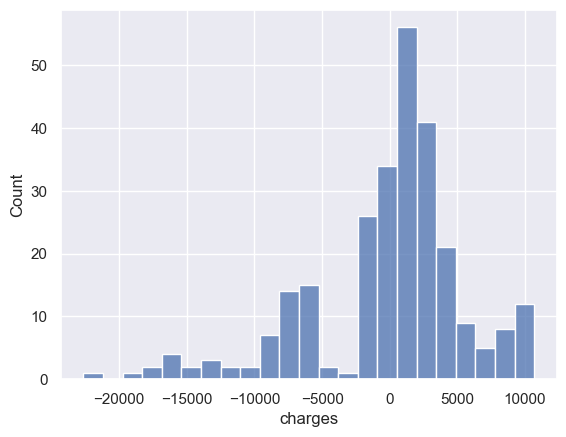

In [108]:
sns.set_theme(color_codes=True)
sns.histplot(residuals,fill=True)

<AxesSubplot: xlabel='charges', ylabel='Density'>

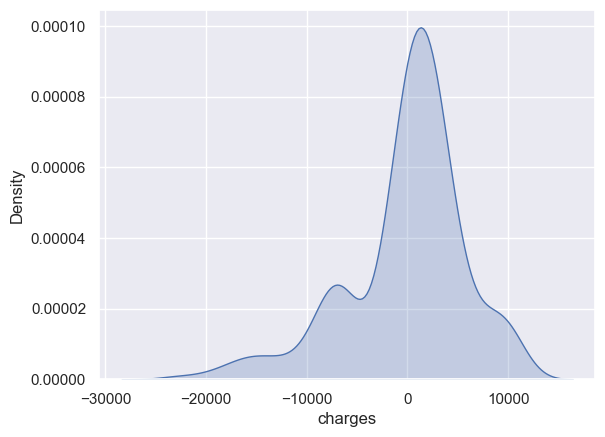

In [109]:
## Kde Plot
sns.set_theme(color_codes=True)
sns.kdeplot(residuals, fill=True)

In [111]:
## 2. Skewness test

residuals.skew()

-1.0034558351294083

In [112]:
residuals = y_pred_te - y_test
residuals

1275     1146.05200
929      7336.93530
992      1659.53270
55      -8624.49445
320       313.24670
           ...     
1141   -17845.99378
1220      350.49170
807      1436.49340
800      1486.15370
0        9139.07600
Name: charges, Length: 268, dtype: float64

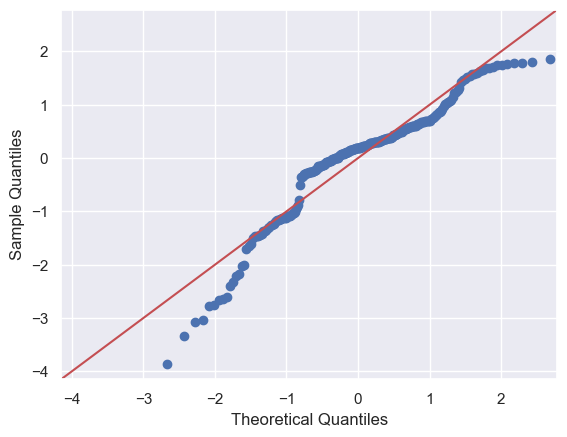

<Figure size 1000x800 with 0 Axes>

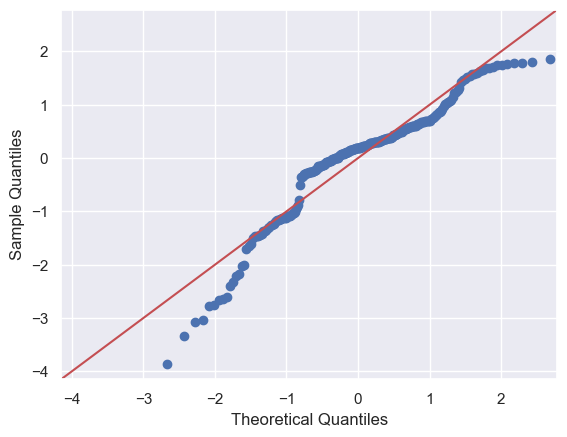

In [113]:
# 3. QQ-Plot
import statsmodels.api as sm
plt.figure(figsize=(10,8))
sm.qqplot(residuals, line="45", fit=True)

In [125]:
## hypothesis test
# 1. shapiro test
from scipy.stats import shapiro, kstest, normaltest

stat, p_value = shapiro(residuals)

if p_value >= 0.05:
    print("Null Hypotheis is True")
    print("All the points are normally distributed")
else:
    print("Alternate hypothesis is True\nAll the residuals are not normally distributed")
print(f"P_value = {p_value}")

print("*"*50)

# 2. KsTest
stat, p_value = kstest(residuals, cdf=f"norm")
if p_value >= 0.05:
    print("Null Hypotheis is True")
    print("All the points are normally distributed")
else:
    print("Alternate hypothesis is True\nAll the residuals are not normally distributed")
print(f"P_value = {p_value}")

print("*"*50)

# 3. Normal test
stat, p_value = normaltest(residuals)
if p_value >= 0.05:
    print("Null Hypotheis is True")
    print("All the points are normally distributed")
else:
    print("Alternate hypothesis is True\nAll the residuals are not normally distributed")
print(f"P_value = {p_value}")

Alternate hypothesis is True
All the residuals are not normally distributed
P_value = 1.0203280581544405e-10
**************************************************
Alternate hypothesis is True
All the residuals are not normally distributed
P_value = 1.2237261044917123e-95
**************************************************
Alternate hypothesis is True
All the residuals are not normally distributed
P_value = 1.336235448108649e-10


In [131]:
dataset.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [132]:
dataset.head(1)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.9,0,yes,southwest,16884.924


In [135]:
def prediction(age, sex, bmi, children, smoker):
    preds = pipe.predict(pd.DataFrame([[age, sex, bmi, children, smoker]],
                             columns=['age', 'sex', 'bmi', 'children', 'smoker']))
    return preds[0]


prediction(19,"female", 27.9, 0,"yes" )

26024.0

In [130]:
import pickle
pickle.dump(pipe, open("model.pkl", "wb"))